In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
# !pip install pyro-ppl

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.datasets import ImageFolder
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision import datasets

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np

In [3]:
def load_images(image_size=(40,40), batch_size=64, root="../datasets/MainImageFolder"):

    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_set = datasets.ImageFolder(root=root, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    return train_loader 

In [4]:
batch_size = 256
train_ld = load_images(root='./train/')
train_ld1 = load_images(root='./train/')

In [5]:
print(len(train_ld.dataset))
validation_split = 0.3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_ld.dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

22424


In [6]:
def get_same_index(target, label):
    label_indices = []
    
    for i in range(len(target)):
        if target[i][1] == label:
            label_indices.append(i)

    return label_indices

In [7]:
ind = get_same_index(train_ld.dataset.samples,0)
sampler_chk1 = torch.utils.data.sampler.SubsetRandomSampler(ind)

In [8]:
len(sampler_chk1)

2489

In [9]:
train_idx1 = list(set(train_idx) - set(sampler_chk1))
print(len(train_idx1))

valid_idx1 = list(set(valid_idx) - set(sampler_chk1))
len(valid_idx1)

13913


6022

In [10]:
train_data = train_ld.dataset
train_data1 = train_ld1.dataset

train_sampler = SubsetRandomSampler(train_idx1)
valid_sampler = SubsetRandomSampler(valid_idx1)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
print(len(train_loader.sampler))
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
print(len(valid_loader.sampler))
valid_loader_ooc = torch.utils.data.DataLoader(train_data1, batch_size=batch_size, 
    sampler=sampler_chk1)
print(len(valid_loader_ooc.sampler))

13913
6022
2489


In [11]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.out = nn.Linear(hidden_size[2], output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output)
        output = F.relu(output)
        output = self.out(output)
        return output

In [12]:
#Dimensions
dim = 40*40*3
dim

4800

In [13]:
net = NN(dim, [2048,1024,512], 10)
net.fc1.weight.shape

torch.Size([2048, 4800])

In [14]:
print(net.fc2.weight.shape)
net.fc3.weight.shape

torch.Size([1024, 2048])


torch.Size([512, 1024])

In [15]:
log_softmax = nn.LogSoftmax(dim=1)

In [16]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))
    
    fc3w_prior = Normal(loc=torch.zeros_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3b_prior = Normal(loc=torch.zeros_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
              'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
              'fc3.weight': fc3w_prior, 'fc3.bias': fc3b_prior,
              'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [17]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # Second layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    
    # Second layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    
    # Third layer weight distribution priors
    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_prior = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param)
    
    # Third layer bias distribution priors
    fc3b_mu = torch.randn_like(net.fc3.bias)
    fc3b_sigma = torch.randn_like(net.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_prior = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
              'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
              'fc3.weight': fc3w_prior, 'fc3.bias': fc3b_prior,
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [18]:
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 50
loss = 0
loss_tr = []

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,dim), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    loss_tr.append(total_epoch_loss_train)
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  1489335.6984142622
Epoch  1  Loss  1237516.193625883
Epoch  2  Loss  1003611.1968710787
Epoch  3  Loss  880116.3183818151
Epoch  4  Loss  732969.9040519302
Epoch  5  Loss  651926.0000691535
Epoch  6  Loss  600437.33739801
Epoch  7  Loss  530023.2363073123
Epoch  8  Loss  498190.60210318776
Epoch  9  Loss  440688.44095772255
Epoch  10  Loss  409508.4472975816
Epoch  11  Loss  380744.7476058939
Epoch  12  Loss  363521.89607579017
Epoch  13  Loss  354797.25308985024
Epoch  14  Loss  310327.9889377143
Epoch  15  Loss  291276.377021278
Epoch  16  Loss  271320.104035192
Epoch  17  Loss  257017.28685821465
Epoch  18  Loss  235875.2528550348
Epoch  19  Loss  234616.64019719366
Epoch  20  Loss  220664.59948457216
Epoch  21  Loss  210385.6606556886
Epoch  22  Loss  197864.50801952137
Epoch  23  Loss  186949.90856290964
Epoch  24  Loss  178810.3914751425
Epoch  25  Loss  171116.93146307766
Epoch  26  Loss  160378.92801496605
Epoch  27  Loss  148744.23368488223
Epoch  28  Loss  143

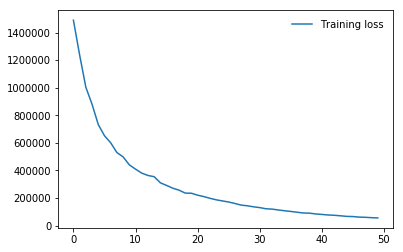

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_tr, label='Training loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
# torch.save(net.state_dict(), ckpt_name)

In [22]:
num_samples = 100
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(valid_loader):
    images, labels = data
    predicted = predict(images.view(-1,dim))
    total += labels.size(0)
#     print((predicted))
#     print(labels.numpy())
    correct += (predicted == labels.numpy()).sum().item()
    break
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 25 %


In [ ]:
# num_samples = 1

# print('Prediction when network is forced to predict')
# correct = 0
# total = 0
# for j, data in enumerate(valid_loader):
#     images, labels = data
#     predicted = predict(images.view(-1,dim))
#     total += labels.size(0)
# #     print((predicted))
# #     print(labels.numpy())
#     correct += (predicted == labels.numpy()).sum().item()
#     break
# print("accuracy: %d %%" % (100 * correct / total))

In [ ]:
# num_samples = 100

# print('Prediction when network is forced to predict')
# correct = 0
# total = 0
# for j, data in enumerate(valid_loader_ooc):
#     images, labels = data
#     predicted = predict(images.view(-1,dim))
#     total += labels.size(0)
# #     print((predicted))
# #     print(labels.numpy())
#     correct += (predicted == labels.numpy()).sum().item()
#     break
# print("accuracy: %d %%" % (100 * correct / total))

In [23]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [35]:
num_samples = 10
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,dim)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [32]:
# classes = ('c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9')
classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

In [33]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 9, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.1): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [36]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(valid_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total input images: ", total)
print("Skipped images: ", total-total_predicted_for)
print("Accuracy, when attempted predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total input images:  6022
Skipped images:  5871
Accuracy, when attempted predictions: 27 %


In [37]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(valid_loader_ooc):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped images: ", total-total_predicted_for)
print("Accuracy, when attempted predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  2489
Skipped images:  2441
Accuracy, when attempted predictions: 0 %


In [ ]:
# # preparing for evaluation
# dataiter = iter(valid_loader_ooc)
# images, labels = dataiter.next()

# test_batch(images, labels)